In [48]:
using RxInfer, Random, LinearAlgebra, Plots, Flux, Plots, StableRNGs, SpecialFunctions, Rocket
using CCMP
using Turing
using DynamicHMC, AdvancedVI
using BenchmarkTools

In [2]:
# data generating process
nr_observations = 50
reference_point = 53
hidden_location = collect(1:nr_observations) + rand(MersenneTwister(124), NormalMeanVariance(0.0, sqrt(100)), nr_observations)
measurements = (hidden_location .- reference_point).^2 + rand(MersenneTwister(124), NormalMeanVariance(0.0, 200), nr_observations);

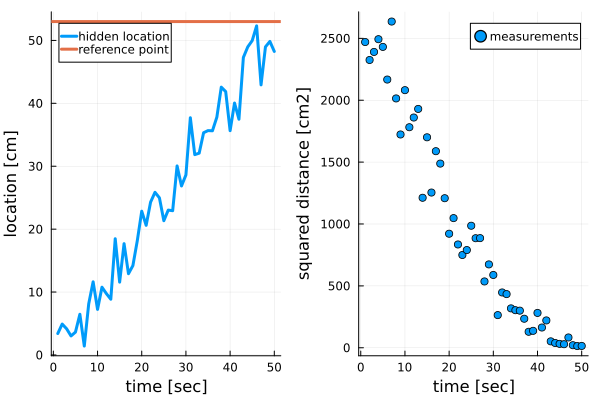

In [3]:
# plot hidden location and reference frame
p1 = plot(1:nr_observations, hidden_location, linewidth=3, legend=:topleft, label="hidden location")
hline!([reference_point], linewidth=3, label="reference point")
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot measurements
p2 = scatter(1:nr_observations, measurements, linewidth=3, label="measurements")
xlabel!("time [sec]"), ylabel!("squared distance [cm2]")

plot(p1, p2)

In [4]:
savefig("square_observations")

"/Users/mykola/repos/CIExpirements/demos/square_observations.png"

In [5]:
function compute_squared_distance(z)
    (z - reference_point)^2
end;

In [6]:
RxInfer.@model function measurement_model(nr_observations)

    # allocate random variables and observations
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)

    # set priors on precision parameters
    τ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    γ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    
    # specify estimate of initial location
    z[1] ~ Normal(mean = 0, precision = τ)
    y[1] ~ Normal(mean = compute_squared_distance(z[1]), precision = γ)

    # loop over observations
    for t in 2:nr_observations

        # specify state transition model
        z[t] ~ Normal(mean = z[t-1] + 1, precision = τ)

        # specify non-linear observation model
        y[t] ~ Normal(mean = compute_squared_distance(z[t]), precision = γ)
        
    end

end

In [7]:
@meta function measurement_meta(rng, nr_samples, nr_iterations, optimizer)
    compute_squared_distance() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 10, Val(false), false)
end;

In [8]:
@constraints function measurement_constraints()
    q(z, τ, γ) = q(z)q(τ)q(γ)
end;

In [9]:
results_cvi = inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 50,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 200, 10, Descent(0.001)),
    initmessages = (z = NormalMeanVariance(0, 5),),
    initmarginals = (z = NormalMeanVariance(0, 5), τ = GammaShapeRate(1.0, 1000), γ = GammaShapeRate(1.0, 1000),),
)

Inference results:
  Posteriors       | available for (z)
  Free Energy:     | Real[438.92, 452.331, 446.074, 446.476, 449.328, 448.969, 449.81, 449.948, 447.994, 449.332  …  418.85, 417.681, 416.909, 416.215, 416.117, 415.309, 414.318, 413.415, 412.729, 413.065]


In [51]:
@benchmark inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 50,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 200, 10, Descent(0.001)),
    initmessages = (z = NormalMeanVariance(0, 5),),
    initmarginals = (z = NormalMeanVariance(0, 5), τ = GammaShapeRate(1.0, 1000), γ = GammaShapeRate(1.0, 1000),),
)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  647.361 ms … 678.850 ms  ┊ GC (min … max): 3.28% … 6.19%
 Time  (median):     672.760 ms               ┊ GC (median):    6.28%
 Time  (mean ± σ):   666.838 ms ±  12.664 ms  ┊ GC (mean ± σ):  5.21% ± 1.59%

  █         █      █                          █        █ █   ██  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁█▁▁▁██ ▁
  647 ms           Histogram: frequency by time          679 ms <

 Memory estimate: 355.76 MiB, allocs estimate: 11059792.

In [10]:
@rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple{1}, M <: CVI} = begin
    method = ReactiveMP.getmethod(meta)
    node = getnode()
    m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
    m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))
    q_y_params = naturalparams(prod(method, getdata(m_ins[1]), getdata(m_out), q_ins[1], getnodefn(Val(:out))))
    return convert(Distribution, q_y_params - naturalparams(getdata(m_out)))
end

In [11]:
results_ccmp = inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 50,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 200, 10, Descent(0.008)),
    initmessages = (z = NormalMeanVariance(0, 5),),
    initmarginals = (z = NormalMeanVariance(0, 5), τ = GammaShapeRate(1.0, 1000), γ = GammaShapeRate(1.0, 1000),),
)

Inference results:
  Posteriors       | available for (z)
  Free Energy:     | Real[559.26, 438.928, 423.214, 418.7, 414.281, 409.274, 405.503, 403.736, 401.308, 401.338  …  391.93, 391.801, 391.658, 391.622, 391.53, 391.444, 391.322, 391.218, 391.21, 391.044]


In [12]:
@meta function linear_measurement_meta()
    compute_squared_distance() -> Linearization()
end;

In [13]:
results_linear = inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 50,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = linear_measurement_meta(),
    initmessages = (z = NormalMeanVariance(0, 100),),
    initmarginals = (z = NormalMeanVariance(0, 100), τ = GammaShapeRate(1, 1000), γ = GammaShapeRate(1, 1000),),
)

Inference results:
  Posteriors       | available for (z)
  Free Energy:     | Real[422.479, 400.323, 399.233, 393.823, 392.22, 391.933, 391.798, 391.714, 391.65, 391.591  …  390.181, 390.141, 390.1, 390.059, 390.019, 389.978, 389.938, 389.897, 389.857, 389.817]


In [52]:
@benchmark inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 50,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = linear_measurement_meta(),
    initmessages = (z = NormalMeanVariance(0, 100),),
    initmarginals = (z = NormalMeanVariance(0, 100), τ = GammaShapeRate(1, 1000), γ = GammaShapeRate(1, 1000),),
)

BenchmarkTools.Trial: 95 samples with 1 evaluation.
 Range (min … max):  49.456 ms … 74.071 ms  ┊ GC (min … max): 0.00% … 29.71%
 Time  (median):     50.682 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   52.696 ms ±  6.684 ms  ┊ GC (mean ± σ):  3.87% ±  8.66%

  ▂▁▅█                                                         
  ████▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▁▃▄ ▁
  49.5 ms         Histogram: frequency by time          74 ms <

 Memory estimate: 21.48 MiB, allocs estimate: 637738.

In [14]:
# Turing model definition.
Turing.@model function NonlinearFiltering(y, r_point)
    # Get observation length.
    N = length(y)

    # State sequence.
    s = tzeros(Int, N)

    # set priors on precision parameters
    τ ~ Gamma(1.0, 1.0e-12)
    γ ~ Gamma(1.0, 1.0e-12)

    # Observe each point of the input.
    s[1] ~ Turing.Normal(0, τ)
    y[1] ~ Turing.Normal((s[1]-r_point)^2, τ)

    for i in 2:N
        s[i] ~ Turing.Normal(s[i-1] + 1, τ)
        y[i] ~ Turing.Normal((s[i]-r_point)^2, γ)
    end
end;
model = NonlinearFiltering(measurements, reference_point)

DynamicPPL.Model{typeof(NonlinearFiltering), (:y, :r_point), (), (), Tuple{Vector{Float64}, Int64}, Tuple{}, DynamicPPL.DefaultContext}(NonlinearFiltering, (y = [2470.235393733442, 2325.219490861669, 2390.1960804010614, 2493.140286092835, 2430.9281458279984, 2167.0752578998745, 2635.7796600262977, 2014.537261227006, 1723.287794104091, 2081.343956668728  …  163.5366273198292, 220.823980051994, 51.75194422139158, 38.446795064708645, 31.410193321197557, 28.7123839864023, 83.12669430851457, 20.559231292389978, 13.739213968976847, 14.750756708287287], r_point = 53), NamedTuple(), DynamicPPL.DefaultContext())

In [15]:
advi = ADVI(100, 100)
q = vi(model, advi);
AdvancedVI.elbo(advi, q, model, 100000)

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 2753084224200849835
└ @ AdvancedVI /Users/mykola/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:202


[ADVI] Optimizing...   2%  ETA: 0:01:43

[ADVI] Optimizing...  20%  ETA: 0:00:15

[ADVI] Optimizing...  35%  ETA: 0:00:09

[ADVI] Optimizing...  48%  ETA: 0:00:06

[ADVI] Optimizing...  62%  ETA: 0:00:04

[ADVI] Optimizing...  76%  ETA: 0:00:03

[ADVI] Optimizing...  89%  ETA: 0:00:01

[ADVI] Optimizing... 100% Time: 0:00:09


-3.064515708403009e11

In [49]:
@benchmark vi(model, advi)

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 4158690067138828297
└ @ AdvancedVI /Users/mykola/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:202


[ADVI] Optimizing...  13%  ETA: 0:00:07

[ADVI] Optimizing...  27%  ETA: 0:00:06

[ADVI] Optimizing...  40%  ETA: 0:00:05

[ADVI] Optimizing...  53%  ETA: 0:00:04

[ADVI] Optimizing...  66%  ETA: 0:00:03

[ADVI] Optimizing...  79%  ETA: 0:00:02

[ADVI] Optimizing...  92%  ETA: 0:00:01

[ADVI] Optimizing... 100% Time: 0:00:07


┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 14689583106919880981
└ @ AdvancedVI /Users/mykola/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:202


[ADVI] Optimizing...  13%  ETA: 0:00:07

[ADVI] Optimizing...  26%  ETA: 0:00:06

[ADVI] Optimizing...  39%  ETA: 0:00:05

[ADVI] Optimizing...  53%  ETA: 0:00:04

[ADVI] Optimizing...  66%  ETA: 0:00:03

[ADVI] Optimizing...  79%  ETA: 0:00:02

[ADVI] Optimizing...  92%  ETA: 0:00:01

[ADVI] Optimizing... 100% Time: 0:00:07


┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 6546838109390492112
└ @ AdvancedVI /Users/mykola/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:202


[ADVI] Optimizing...  14%  ETA: 0:00:06

[ADVI] Optimizing...  28%  ETA: 0:00:05

[ADVI] Optimizing...  42%  ETA: 0:00:04

[ADVI] Optimizing...  56%  ETA: 0:00:03

[ADVI] Optimizing...  70%  ETA: 0:00:02

[ADVI] Optimizing...  84%  ETA: 0:00:01

[ADVI] Optimizing...  98%  ETA: 0:00:00

[ADVI] Optimizing... 100% Time: 0:00:07


┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 6546838109390492112
└ @ AdvancedVI /Users/mykola/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:202


[ADVI] Optimizing...  14%  ETA: 0:00:06

[ADVI] Optimizing...  28%  ETA: 0:00:05

[ADVI] Optimizing...  43%  ETA: 0:00:04

[ADVI] Optimizing...  58%  ETA: 0:00:03

[ADVI] Optimizing...  72%  ETA: 0:00:02

[ADVI] Optimizing...  86%  ETA: 0:00:01

[ADVI] Optimizing... 100% Time: 0:00:07


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.219 s (27.34% GC) to evaluate,
 with a memory estimate of 25.29 GiB, over 71772585 allocations.

In [53]:
chn = sample(model, DynamicNUTS(), 3000);
chn2 = sample(model, HMC(0.01, 1000), 1000);

Sampling   0%|                                          |  ETA: N/A


Sampling   0%|▎                                         |  ETA: 0:02:00
Sampling   1%|▍                                         |  ETA: 0:01:00
Sampling   2%|▋                                         |  ETA: 0:00:40
Sampling   2%|▉                                         |  ETA: 0:00:30
Sampling   2%|█                                         |  ETA: 0:00:24
Sampling   3%|█▎                                        |  ETA: 0:00:20
Sampling   4%|█▌                                        |  ETA: 0:00:17
Sampling   4%|█▋                                        |  ETA: 0:00:15
Sampling   4%|█▉                                        |  ETA: 0:00:13
Sampling   5%|██▏                                       |  ETA: 0:00:12
Sampling   6%|██▎                                       |  ETA: 0:00:11
Sampling   6%|██▌                                       |  ETA: 0:00:10
Sampling   6%|██▊                                       |  ETA: 0:00:09
Sampling   7%|███                                       |  ETA: 

Sampling  16%|██████▉                                   |  ETA: 0:00:04
Sampling  17%|███████▏                                  |  ETA: 0:00:03
Sampling  18%|███████▍                                  |  ETA: 0:00:03
Sampling  18%|███████▌                                  |  ETA: 0:00:03
Sampling  18%|███████▊                                  |  ETA: 0:00:03
Sampling  19%|████████                                  |  ETA: 0:00:03
Sampling  20%|████████▎                                 |  ETA: 0:00:03
Sampling  20%|████████▍                                 |  ETA: 0:00:03
Sampling  20%|████████▋                                 |  ETA: 0:00:03
Sampling  21%|████████▉                                 |  ETA: 0:00:03
Sampling  22%|█████████                                 |  ETA: 0:00:03
Sampling  22%|█████████▎                                |  ETA: 0:00:03
Sampling  22%|█████████▌                                |  ETA: 0:00:03
Sampling  23%|█████████▋                                |  ETA: 

Sampling  30%|████████████▍                             |  ETA: 0:00:02
Sampling  30%|████████████▋                             |  ETA: 0:00:02
Sampling  30%|████████████▊                             |  ETA: 0:00:02
Sampling  31%|█████████████                             |  ETA: 0:00:02
Sampling  32%|█████████████▎                            |  ETA: 0:00:02
Sampling  32%|█████████████▌                            |  ETA: 0:00:02
Sampling  32%|█████████████▋                            |  ETA: 0:00:02
Sampling  33%|█████████████▉                            |  ETA: 0:00:02
Sampling  34%|██████████████▏                           |  ETA: 0:00:02
Sampling  34%|██████████████▎                           |  ETA: 0:00:02
Sampling  34%|██████████████▌                           |  ETA: 0:00:02
Sampling  35%|██████████████▊                           |  ETA: 0:00:02
Sampling  36%|██████████████▉                           |  ETA: 0:00:02
Sampling  36%|███████████████▏                          |  ETA: 

Sampling  45%|██████████████████▉                       |  ETA: 0:00:01
Sampling  46%|███████████████████▏                      |  ETA: 0:00:01
Sampling  46%|███████████████████▍                      |  ETA: 0:00:01
Sampling  46%|███████████████████▌                      |  ETA: 0:00:01
Sampling  47%|███████████████████▊                      |  ETA: 0:00:01
Sampling  48%|████████████████████                      |  ETA: 0:00:01
Sampling  48%|████████████████████▏                     |  ETA: 0:00:01
Sampling  48%|████████████████████▍                     |  ETA: 0:00:01
Sampling  49%|████████████████████▋                     |  ETA: 0:00:01
Sampling  50%|████████████████████▊                     |  ETA: 0:00:01
Sampling  50%|█████████████████████                     |  ETA: 0:00:01
Sampling  50%|█████████████████████▎                    |  ETA: 0:00:01
Sampling  51%|█████████████████████▍                    |  ETA: 0:00:01
Sampling  52%|█████████████████████▋                    |  ETA: 

Sampling  57%|████████████████████████▏                 |  ETA: 0:00:01
Sampling  58%|████████████████████████▍                 |  ETA: 0:00:01
Sampling  58%|████████████████████████▋                 |  ETA: 0:00:01
Sampling  59%|████████████████████████▊                 |  ETA: 0:00:01
Sampling  60%|█████████████████████████                 |  ETA: 0:00:01
Sampling  60%|█████████████████████████▎                |  ETA: 0:00:01
Sampling  60%|█████████████████████████▍                |  ETA: 0:00:01
Sampling  61%|█████████████████████████▋                |  ETA: 0:00:01
Sampling  62%|█████████████████████████▉                |  ETA: 0:00:01
Sampling  62%|██████████████████████████                |  ETA: 0:00:01
Sampling  62%|██████████████████████████▎               |  ETA: 0:00:01
Sampling  63%|██████████████████████████▌               |  ETA: 0:00:01
Sampling  64%|██████████████████████████▋               |  ETA: 0:00:01
Sampling  64%|██████████████████████████▉               |  ETA: 

Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:00
Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:00
Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:00
Sampling  74%|███████████████████████████████▎          |  ETA: 0:00:00
Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:00
Sampling  76%|███████████████████████████████▊          |  ETA: 0:00:00
Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:00
Sampling  76%|████████████████████████████████▏         |  ETA: 0:00:00
Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:00
Sampling  78%|████████████████████████████████▌         |  ETA: 0:00:00
Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:00
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:00
Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:00
Sampling  80%|█████████████████████████████████▍        |  ETA: 

Sampling  86%|███████████████████████████████████▉      |  ETA: 0:00:00
Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:00
Sampling  86%|████████████████████████████████████▍     |  ETA: 0:00:00
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:00
Sampling  88%|████████████████████████████████████▊     |  ETA: 0:00:00
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:00
Sampling  88%|█████████████████████████████████████▏    |  ETA: 0:00:00
Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:00
Sampling  90%|█████████████████████████████████████▋    |  ETA: 0:00:00
Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:00
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:00
Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:00
Sampling  92%|██████████████████████████████████████▍   |  ETA: 0:00:00
Sampling  92%|██████████████████████████████████████▋   |  ETA: 

Sampling   0%|                                          |  ETA: N/A


Sampling   0%|▎                                         |  ETA: 0:06:26
Sampling   1%|▍                                         |  ETA: 0:03:12
Sampling   2%|▋                                         |  ETA: 0:02:08
Sampling   2%|▉                                         |  ETA: 0:01:35
Sampling   2%|█                                         |  ETA: 0:01:16
Sampling   3%|█▎                                        |  ETA: 0:01:03
Sampling   4%|█▌                                        |  ETA: 0:00:54
Sampling   4%|█▋                                        |  ETA: 0:00:47
Sampling   4%|█▉                                        |  ETA: 0:00:41
Sampling   5%|██▏                                       |  ETA: 0:00:37
Sampling   6%|██▎                                       |  ETA: 0:00:34
Sampling   6%|██▌                                       |  ETA: 0:00:31
Sampling   6%|██▊                                       |  ETA: 0:00:28
Sampling   7%|███                                       |  ETA: 

Sampling  33%|█████████████▉                            |  ETA: 0:00:04
Sampling  34%|██████████████▏                           |  ETA: 0:00:04
Sampling  34%|██████████████▎                           |  ETA: 0:00:04
Sampling  34%|██████████████▌                           |  ETA: 0:00:04
Sampling  35%|██████████████▊                           |  ETA: 0:00:04
Sampling  36%|██████████████▉                           |  ETA: 0:00:04
Sampling  36%|███████████████▏                          |  ETA: 0:00:04
Sampling  36%|███████████████▍                          |  ETA: 0:00:04
Sampling  37%|███████████████▌                          |  ETA: 0:00:04
Sampling  38%|███████████████▊                          |  ETA: 0:00:03
Sampling  38%|████████████████                          |  ETA: 0:00:03
Sampling  38%|████████████████▏                         |  ETA: 0:00:03
Sampling  39%|████████████████▍                         |  ETA: 0:00:03
Sampling  40%|████████████████▋                         |  ETA: 

Sampling  74%|██████████████████████████████▉           |  ETA: 0:00:01
Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:01
Sampling  74%|███████████████████████████████▎          |  ETA: 0:00:01
Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:01


Sampling  76%|███████████████████████████████▊          |  ETA: 0:00:01
Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:01
Sampling  76%|████████████████████████████████▏         |  ETA: 0:00:01
Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:01
Sampling  78%|████████████████████████████████▌         |  ETA: 0:00:01
Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:01
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:01
Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:01
Sampling  80%|█████████████████████████████████▍        |  ETA: 0:00:01
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:01
Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:01
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:01
Sampling  82%|██████████████████████████████████▎       |  ETA: 0:00:00
Sampling  82%|██████████████████████████████████▌       |  ETA: 

In [54]:
@benchmark sample(model, DynamicNUTS(), 3000)

Sampling   0%|                                          |  ETA: N/A


Sampling   0%|▎                                         |  ETA: 0:02:08
Sampling   1%|▍                                         |  ETA: 0:01:04
Sampling   2%|▋                                         |  ETA: 0:00:43
Sampling   2%|▉                                         |  ETA: 0:00:32
Sampling   2%|█                                         |  ETA: 0:00:26
Sampling   3%|█▎                                        |  ETA: 0:00:21
Sampling   4%|█▌                                        |  ETA: 0:00:18
Sampling   4%|█▋                                        |  ETA: 0:00:16
Sampling   4%|█▉                                        |  ETA: 0:00:14
Sampling   5%|██▏                                       |  ETA: 0:00:13
Sampling   6%|██▎                                       |  ETA: 0:00:12
Sampling   6%|██▌                                       |  ETA: 0:00:11
Sampling   6%|██▊                                       |  ETA: 0:00:10
Sampling   7%|███                                       |  ETA: 

Sampling  14%|█████▉                                    |  ETA: 0:00:05
Sampling  14%|██████▏                                   |  ETA: 0:00:04
Sampling  15%|██████▎                                   |  ETA: 0:00:04
Sampling  16%|██████▌                                   |  ETA: 0:00:04
Sampling  16%|██████▊                                   |  ETA: 0:00:04
Sampling  16%|██████▉                                   |  ETA: 0:00:04
Sampling  17%|███████▏                                  |  ETA: 0:00:04
Sampling  18%|███████▍                                  |  ETA: 0:00:04
Sampling  18%|███████▌                                  |  ETA: 0:00:03
Sampling  18%|███████▊                                  |  ETA: 0:00:03
Sampling  19%|████████                                  |  ETA: 0:00:03
Sampling  20%|████████▎                                 |  ETA: 0:00:03
Sampling  20%|████████▍                                 |  ETA: 0:00:03
Sampling  20%|████████▋                                 |  ETA: 

Sampling  31%|█████████████                             |  ETA: 0:00:02
Sampling  32%|█████████████▎                            |  ETA: 0:00:02
Sampling  32%|█████████████▌                            |  ETA: 0:00:02
Sampling  32%|█████████████▋                            |  ETA: 0:00:02
Sampling  33%|█████████████▉                            |  ETA: 0:00:02
Sampling  34%|██████████████▏                           |  ETA: 0:00:02
Sampling  34%|██████████████▎                           |  ETA: 0:00:02
Sampling  34%|██████████████▌                           |  ETA: 0:00:02
Sampling  35%|██████████████▊                           |  ETA: 0:00:02
Sampling  36%|██████████████▉                           |  ETA: 0:00:02
Sampling  36%|███████████████▏                          |  ETA: 0:00:02
Sampling  36%|███████████████▍                          |  ETA: 0:00:02
Sampling  37%|███████████████▌                          |  ETA: 0:00:01
Sampling  38%|███████████████▊                          |  ETA: 

Sampling  44%|██████████████████▌                       |  ETA: 0:00:01
Sampling  44%|██████████████████▊                       |  ETA: 0:00:01
Sampling  45%|██████████████████▉                       |  ETA: 0:00:01
Sampling  46%|███████████████████▏                      |  ETA: 0:00:01
Sampling  46%|███████████████████▍                      |  ETA: 0:00:01
Sampling  46%|███████████████████▌                      |  ETA: 0:00:01
Sampling  47%|███████████████████▊                      |  ETA: 0:00:01
Sampling  48%|████████████████████                      |  ETA: 0:00:01
Sampling  48%|████████████████████▏                     |  ETA: 0:00:01
Sampling  48%|████████████████████▍                     |  ETA: 0:00:01
Sampling  49%|████████████████████▋                     |  ETA: 0:00:01
Sampling  50%|████████████████████▊                     |  ETA: 0:00:01
Sampling  50%|█████████████████████                     |  ETA: 0:00:01
Sampling  50%|█████████████████████▎                    |  ETA: 

Excessive output truncated after 524383 bytes.

Sampling  61%|█████████████████████████▋                |  ETA: 0:00:01
Sampling  62%|█████████████████████████▉                |  ETA: 0:00:01
Sampling  62%|██████████████████████████                |  ETA: 0:00:01
Sampling  62%|██████████████████████████▎               |  ETA: 0:00:01
Sampling  63%|██████████████████████████▌               |  ETA: 0:00:01
Sampling  64%|██████████████████████████▋               |  ETA: 0:00:01
Sampling  64%|██████████████████████████▉               |  ETA: 0:00:01
Sampling  64%|███████████████████████████▏              |  ETA: 0:00:01
Sampling  65%|███████████████████████████▎              |  ETA: 0:00:01
Sampling  66%|███████████████████████████▌              |  ETA: 0:00:01
Sampling  66%|███████████████████████████▊              |  ETA: 0:00:01
Sampling  66%|███████████████████████████▉              |  ETA: 0:00:01
Sampling  67%|████████████████████████████▏             |  ETA: 0:00:01
Sampling  68%|████████████████████████████▍             |  ETA: 

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.371 s …    2.262 s  ┊ GC (min … max):  8.76% … 9.80%
 Time  (median):     1.501 s               ┊ GC (median):    10.72%
 Time  (mean ± σ):   1.711 s ± 481.436 ms  ┊ GC (mean ± σ):   9.79% ± 0.98%

  █       █                                                █  
  █▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.37 s         Histogram: frequency by time         2.26 s <

 Memory estimate: 1.61 GiB, allocs estimate: 9404927.

In [58]:
@benchmark sample(model, HMC(0.01, 1000), 3000)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  829.076 ms … 863.968 ms  ┊ GC (min … max):  8.66% … 12.37%
 Time  (median):     841.983 ms               ┊ GC (median):    10.56%
 Time  (mean ± σ):   844.056 ms ±  12.544 ms  ┊ GC (mean ± σ):  10.44% ±  1.25%

  █         █       █       █             █                   █  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  829 ms           Histogram: frequency by time          864 ms <

 Memory estimate: 934.72 MiB, allocs estimate: 6611421.

In [56]:
q_samples = rand(q, 1000)
s_posteriors = Vector{Any}(undef,50)
s2_posteriors = Vector{Any}(undef,50)
q_s_posteriors = Vector{Any}(undef,50)
for i in 1:50
    s_posteriors[i] = chn["s[$(i)]"]
    s2_posteriors[i] = chn2["s[$(i)]"]
    q_s_posteriors[i] = q_samples[i,1:1000]
end

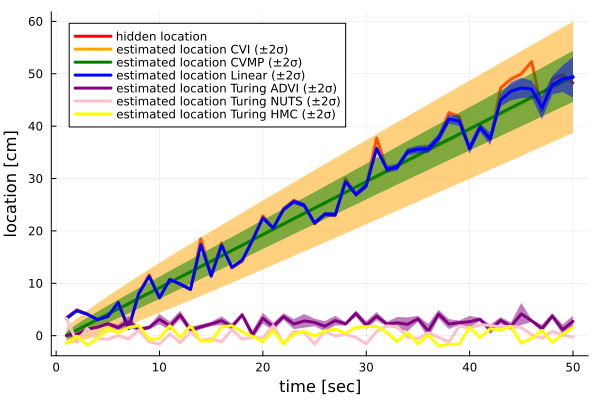

In [57]:
# plot estimates for location
p1 = plot(collect(1:nr_observations), hidden_location, label = "hidden location", legend=:topleft, linewidth=3, color = :red)
plot!(map(mean, results_cvi.posteriors[:z]), label = "estimated location CVI (±2σ)", ribbon = map(x -> 2*std(x), results_cvi.posteriors[:z]), fillalpha=0.5, linewidth=3, color = :orange)
plot!(map(mean, results_ccmp.posteriors[:z]), label = "estimated location CVMP (±2σ)", ribbon = map(x -> 2*std(x), results_ccmp.posteriors[:z]), fillalpha=0.5, linewidth=3, color = :green)
plot!(map(mean, results_linear.posteriors[:z]), label = "estimated location Linear (±2σ)", ribbon = map(x -> 2*std(x), results_linear.posteriors[:z]), fillalpha=0.5, linewidth=3, color = :blue)
plot!(map(mean, q_s_posteriors), label = "estimated location Turing ADVI (±2σ)", ribbon = map(x -> 2*std(x), q_s_posteriors), fillalpha=0.5, linewidth=3, color = :purple)
plot!(map(mean, s_posteriors), label = "estimated location Turing NUTS (±2σ)", ribbon = map(x -> 2*std(x), s_posteriors), fillalpha=0.5, linewidth=3, color = :pink)
plot!(map(mean, s2_posteriors), label = "estimated location Turing HMC (±2σ)", ribbon = map(x -> 2*std(x), s2_posteriors), fillalpha=0.5, linewidth=3, color = :yellow)
xlabel!("time [sec]"), ylabel!("location [cm]")

# # plot Bethe free energy
# p2 = plot(results_cvi.free_energy, linewidth=3, label = "CVI")
# p2 = plot(results_ccmp.free_energy, linewidth=3, label = "CVMP")
# p2 = plot!(results_linear.free_energy, linewidth=3, label = "Linear")
# xlabel!("iteration"), ylabel!("Bethe free energy [nats]")

plot(p1)

In [63]:
mean(map(x -> 2*std(x), results_linear.posteriors[:z]))

0.7442179352660954

In [61]:
mean(map(x -> 2*std(x), results_cvi.posteriors[:z]))

7.102987832018541

In [62]:
mean(map(x -> 2*std(x), results_ccmp.posteriors[:z]))

3.112909171377821

In [64]:
mean(map(x -> 2*std(x), q_s_posteriors))

0.7241894114453199

In [65]:
mean(map(x -> 2*std(x), s_posteriors))

5.092609185627203e-15

In [66]:
mean(map(x -> 2*std(x), s2_posteriors))

6.7229871909330755e-15

In [46]:
savefig("square_observations_results")

"/Users/mykola/repos/CIExpirements/demos/square_observations_results.png"